In [1]:
import os
import time
from googleapiclient.discovery import build
import json
import itertools
import networkx as nx
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
DEVELOPER_KEY = json.load(open('../keys/youtube_key.json'))['api_key']
YOUTUBE_API_SERVICE_NAME = 'youtube'
YOUTUBE_API_VERSION = 'v3'

youtube = build(
    YOUTUBE_API_SERVICE_NAME,
    YOUTUBE_API_VERSION,
    developerKey=DEVELOPER_KEY
)


In [3]:
# 1. First find Channel ID by Channel Name

request = youtube.search().list(
        part="snippet",
        maxResults=5,
        q="TheMerluzz",
        type="channel"
    )

response = request.execute()

channelId = response['items'][0]['id']['channelId']

channelId

'UCBzFCho7e5KLWlfoV-V3p7Q'

In [4]:
request = youtube.channels().list(
    part="snippet,contentDetails",
    id= channelId
    )
response = request.execute()
uploaded_playlist = response['items'][0]['contentDetails']['relatedPlaylists']['uploads']
uploaded_playlist

'UUBzFCho7e5KLWlfoV-V3p7Q'

In [9]:
channel_videos : list = list()

page_token = None

while True:
    request = youtube.playlistItems().list(
            part="snippet,contentDetails",
            maxResults=10,
            playlistId=uploaded_playlist,
            pageToken = page_token
    )

    response = request.execute()

    channel_videos.extend(
        (
            v['contentDetails']['videoId'],
            v['snippet']['title']
        )
        for v in response['items']
    )

    if response.get('nextPageToken', None) is None:
        break

    if len(channel_videos) >= 100:
        break

    page_token = response['nextPageToken']


channel_videos = channel_videos[:100]
len(channel_videos)

100

In [11]:
video_2_words = {
    video_id: set(title.split())
    for video_id, title in channel_videos
}

In [37]:
import time

# Get Comments for Every Video
video_2_comments = dict()

for (video_id, video_title) in channel_videos:
    try:
        page_token = None

        video_commentators : set = set()

        while True:
            request = youtube.commentThreads().list(
                part="snippet",
                videoId=video_id,
                maxResults=100,
                pageToken = page_token
            )

            response = request.execute()


            video_commentators.update(
                (
                    ct['snippet']['topLevelComment']['snippet']['authorDisplayName'],
                    ct['snippet']['topLevelComment']['snippet']['textDisplay']
                )
                for ct in response['items']
            )

            if response.get('nextPageToken', None) is None:
                break

            page_token = response['nextPageToken']

        time.sleep(0.1)
        video_2_comments[video_id] = video_commentators
    except Exception as e:
        print(e)
        video_2_comments[video_id] = set()




In [38]:
video_2_comments = {k: list(v) for k, v in video_2_comments.items()}

json.dump(video_2_comments, open('../data/themerluzz/video2comments.json','w')) # Salviamo i risultati

In [43]:
# Create a Dict that associates every commentator with every word it used in the comments

# UserName: (commented_videos, word_used)
commenters_info : dict[str, tuple[set[str], set[str]]]= dict()

for video_id, comments in video_2_comments.items():
    for author, content in comments:
        words = content.split()

        if author not in commenters_info:
            commenters_info[author] = (set(), set())

        commenters_info[author][0].add(video_id)
        commenters_info[author][1].update(words)


In [47]:
commenters_info["@EraldoPiccione"]

({'BY9ppf2M3kE', 'zd-O24m_60o'},
 {'John?', 'Why', 'Why?', 'forti🎉', 'troppo', '😂😂😂'})

In [48]:
def int_union_ratio(set1, set2):
    return len(set1.intersection(set2))/len(set1.union(set2))


In [50]:
commenters = commenters_info.keys()

commentator_to_id = {
    name: idx
    for idx, name in enumerate(commenters)
}

In [85]:
"""
 Il Grafo G_voc ha:
 * Come nodi, tutti i commentatori
 * Un arco (n1, n2) come il peso della relazione tra n1 ed n2, calcolato a partire dall'insieme delle parole scritte nei commenti da loro (uso union_ratio)
"""

G_voc = nx.Graph()

G_voc.add_nodes_from(commentator_to_id.values())

for u, v in itertools.combinations(commenters, 2):
    u_id, v_id = commentator_to_id[u], commentator_to_id[v]
    u_words, v_words = commenters_info[u][1], commenters_info[v][1]

    weight = int_union_ratio(u_words, v_words)
    if weight and weight > 0:
        G_voc.add_edge(u_id, v_id, weight=weight)


In [88]:
G_voc.size(), G_voc.order()

(10099502, 7658)

In [86]:
"""
Il Grafo G_com ha:
* Come nodi, tutti i commentatori
* Un arco (n1, n2) come il numero di video che hanno commentato entrambi (con un attributo aggiuntivo sim che indica la similarità tra tutt i titoli dei video)
"""

G_com = nx.Graph()

G_com.add_nodes_from(commentator_to_id.values())

# Precompute sim values for every couple
video_coefs = dict()
for v1, v2 in itertools.combinations(list(video_2_words.keys()),2):
    v1_words, v2_words = video_2_words[v1], video_2_words[v2]
    coef = int_union_ratio(v1_words, v2_words)
    if coef and coef > 0:
        video_coefs[(v1,v2)] = coef
        video_coefs[(v2,v1)] = coef


for u, v in itertools.combinations(commenters, 2):
    u_id, v_id = commentator_to_id[u], commentator_to_id[v]
    u_videos, v_videos = commenters_info[u][0], commenters_info[v][0]
    common_videos = u_videos.intersection(v_videos)

    weight = len(common_videos)

    if weight > 0:
        sim = sum(
            int_union_ratio(video_2_words[a], video_2_words[b])
            for a, b in itertools.combinations(common_videos, 2)
        )

        G_com.add_edge(u_id, v_id, weight=weight, sim=sim)


In [87]:
G_com.size(), G_com.order()

(1019944, 7658)

In [75]:
degree_com, degree_voc = dict(nx.degree(G_com)), dict(nx.degree(G_voc))

In [90]:
top_10_com = set(sorted(list(degree_com.keys()), key=degree_com.get, reverse=True)[:10])
top_10_voc = set(sorted(list(degree_voc.keys()), key=degree_voc.get, reverse=True)[:10])

top_10_com.intersection(top_10_voc)

{63, 168, 227, 724}

In [95]:
com_deg_cent, voc_deg_cent = nx.degree_centrality(G_com), nx.degree_centrality(G_voc)

x = [
    com_deg_cent[node_id]
    for node_id in sorted(com_deg_cent.keys())
]
y = [
    voc_deg_cent[node_id]
    for node_id in sorted(voc_deg_cent.keys())
]


stats.kendalltau(x, y).statistic

np.float64(0.11281128023646074)

In [105]:
# Grafo in cui ogni punto rappresenta una coppia di commentatori definita dalle rispettive similarità in G_com e G_voc

points = list()

for u, v in itertools.combinations(commenters, 2):
    u_id, v_id = commentator_to_id[u], commentator_to_id[v]

    try:
        sim_x = G_com.edges[u_id, v_id]['sim']
        sim_y = G_voc.edges[u_id, v_id]['weight']

        if sim_x and sim_y:
            points.append((sim_x, sim_y))
    except:
        pass

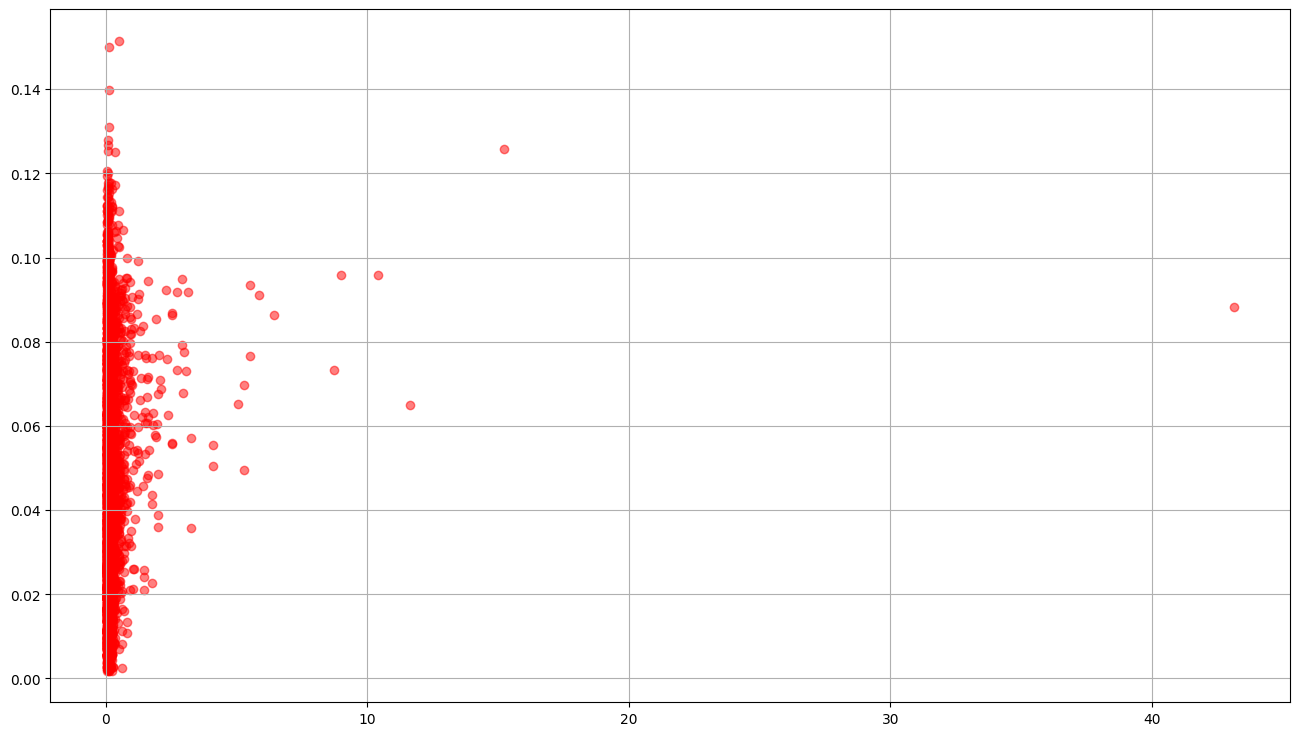

In [106]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot()
x_values, y_values = zip(*points)
ax.scatter(x_values, y_values, color='red', alpha=0.5)
ax.grid(True)
plt.show()